### Set up libraries

In [135]:
import pandas as pd
import numpy as np

from textblob import TextBlob  # for sentiment analysis
import spacy 
# python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

stop_words = spacy.lang.en.stop_words.STOP_WORDS

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances


import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", color_codes=True)
%matplotlib inline

In [134]:
stop_words

{'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'front',
 'full',
 'further',
 'get',
 'give',
 'g

### Import data

In [103]:
# Open the file
df = pd.read_csv('data/news_articles.csv', encoding='unicode_escape')
df = df.iloc[:,0:6]

In [104]:
# Save out the name of news publication
df['source'] = [url.split('/')[2] for url in df['article_source_link']]

In [105]:
# Drop rows with no article text
print('Shape before:', df.shape)
df = df.dropna(subset=['text'])
print('Shape after dropping rows with no article text:', df.shape)

Shape before: (3824, 7)
Shape after dropping rows with no article text: (3791, 7)


### Preprocess data

In [136]:
# Preprocess text
#TODO: Make this more performant and not traverse everything each time? use textblob?
#TODO: Add pydoc comments

def preprocess_text(text):
    # Tokenize
    doc = nlp(text)
#     [token.text for token in doc]

    # Remove punctuation & stopwords
    doc = [t for t in doc if t not in stop_words and t.pos_ != 'PUNCT']

    # Normalize (convert non-text to text)
    
    # Stemming/Lemmatization (& lowercase & strip)
    doc = [t.lemma_.lower().strip() for t in doc]

    return doc

### (testing step - restricting dataset size)

In [108]:
df = df.head(50)
df.shape

# cluster the news articles to figure out what topics they generally are about
# calculate a sentiment score (polarity & subjectivity) for each -- use the mean and rms? (as magnitude measure)
# pull out average polarity (just ran it on entire doc)
# pull out average subjectivity (just ran it on entire article)

# pull out 3 most "intense/polarizing" sentences from very polarized articles



(50, 7)

### Clustering (based on title)

In [96]:
def cluster_text(texts, clusters=3):
    """ Transform texts to Tf-Idf coordinates and cluster texts using K-Means """
    vectorizer = TfidfVectorizer(tokenizer=preprocess_text,
                                 max_df=0.5,
                                 min_df=0.1,
                                 lowercase=True)
     #TODO: play with max & min document frequency

    tfidf_model = vectorizer.fit_transform(texts)
    
    # Return a dataframe of all features (words in the corpus)
#     tfidf_model_array = normalize(tfidf_model).toarray()
#     feature_names = pd.DataFrame(tfidf_model_array, columns=vectorizer.get_feature_names())
    
    # Fit to the model
    #TODO: add a random state
    kmeans = KMeans(n_clusters=clusters).fit(tfidf_model)
 
    return kmeans.labels_

#### Optimizing the clustering

/Users/minna/.conda/envs/news_articles_describing_words/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['-pron-', 'make', 'whatev'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


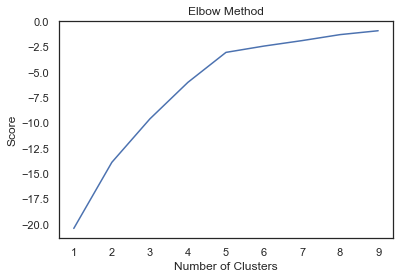

In [143]:
texts = df['title']

vectorizer = TfidfVectorizer(tokenizer=preprocess_text, stop_words='english',
                                 max_df=0.7,
                                 min_df=0.1,
                                 lowercase=True)

tfidf_model = vectorizer.fit_transform(texts)

# Return a dataframe of all features (words in the corpus)
tfidf_model_array = normalize(tfidf_model).toarray()
feature_names = pd.DataFrame(tfidf_model_array, columns=vectorizer.get_feature_names())
    

number_clusters = range(1, 10)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(tfidf_model).score(tfidf_model) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

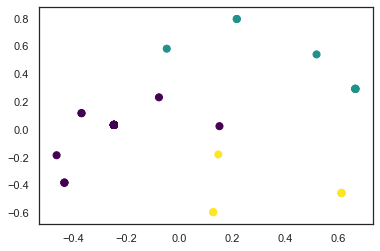

In [144]:
num_clusters = 3

sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tfidf_model_array)
test_e = KMeans(n_clusters=num_clusters, max_iter=600)
fitted = test_e.fit(Y_sklearn)
predicted_values = test_e.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=50, cmap='viridis')

# centers = fitted.centroids
# plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

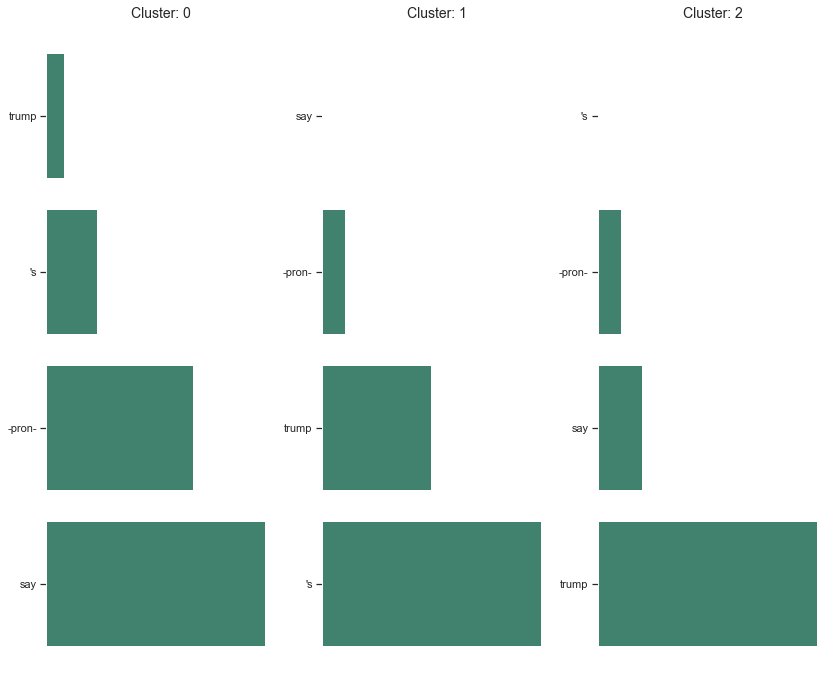

In [145]:
def get_top_features_cluster(tfidf_model_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tfidf_model_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tfidf_model_array, predicted_values, 15)

def plot_features(dfs):
    fig = plt.figure(figsize=(14,12))
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.set_title("Cluster: "+ str(i), fontsize = 14)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#40826d')
        yticks = ax.set_yticklabels(df.features)
        plt.yticks(np.arange(min(x), max(x)+1, 1.0))
        plt.xticks([], [])
    plt.show();
plot_features(dfs)



In [86]:
# cluster based on TITLE
df['cluster'] = cluster_text(df['title'])
df

,new_column,article_id,publish_date,article_source_link,title,subtitle,text,source,pol_sub,polarity,subjectivity,cluster
0,2,1,2017/2/7,http://abcnews.go.com/Politics/pence-break-tie...,"Betsy DeVos Confirmed as Education Secretary, ...",NaN,Michigan billionaire education activist Betsy ...,abcnews.go.com,"(0.030378787878787884, 0.42757575757575755)",0.030379,0.427576,0
1,0,2,2017/2/7,http://abcnews.go.com/Politics/wireStory/melan...,Melania Trump Says White House Could Mean Mill...,NaN,First lady Melania Trump has said little about...,abcnews.go.com,"(0.06409090909090906, 0.37349954771596555)",0.064091,0.373500,1
2,2,3,2017/2/7,http://abcnews.go.com/Politics/wireStory/trump...,"As Trump Fears Fraud, GOP Eliminates Election ...",NaN,A House committee voted on Tuesday to eliminat...,abcnews.go.com,"(0.07278344671201815, 0.39367913832199536)",0.072783,0.393679,0
3,1,4,2017/2/7,http://abcnews.go.com/Politics/appeals-court-d...,Appeals Court to Decide on Challenge to Trump'...,NaN,"This afternoon, three federal judges from the ...",abcnews.go.com,"(0.09401373988330514, 0.4382505175983437)",0.094014,0.438251,2
4,1,5,2017/2/7,http://abcnews.go.com/US/23-states-winter-weat...,At Least 4 Tornadoes Reported in Southeast Lou...,NaN,At least four tornadoes touched down in Louisi...,abcnews.go.com,"(0.02194023569023569, 0.35596921596921605)",0.021940,0.355969,2


In [ ]:
# Visualizing results from the clustering
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizor.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_array, prediction, 15)

### Get sentiment

In [21]:
def get_sentiment(article):
    try:
        return TextBlob(article).sentiment
    except:
        return None

df['pol_sub'] = df.text.apply(get_sentiment)
df['polarity'] = df['pol_sub'].apply(lambda x: x[0])
df['subjectivity'] = df['pol_sub'].apply(lambda x: x[1])

#NOTE: these scores are for entire articles

df


,article_id,publish_date,article_source_link,title,subtitle,text,source,pol_sub,polarity,subjectivity
0,1,2017/2/7,http://abcnews.go.com/Politics/pence-break-tie...,"Betsy DeVos Confirmed as Education Secretary, ...",NaN,Michigan billionaire education activist Betsy ...,abcnews.go.com,"(0.030378787878787884, 0.42757575757575755)",0.030379,0.427576
1,2,2017/2/7,http://abcnews.go.com/Politics/wireStory/melan...,Melania Trump Says White House Could Mean Mill...,NaN,First lady Melania Trump has said little about...,abcnews.go.com,"(0.06409090909090906, 0.37349954771596555)",0.064091,0.373500
2,3,2017/2/7,http://abcnews.go.com/Politics/wireStory/trump...,"As Trump Fears Fraud, GOP Eliminates Election ...",NaN,A House committee voted on Tuesday to eliminat...,abcnews.go.com,"(0.07278344671201815, 0.39367913832199536)",0.072783,0.393679
3,4,2017/2/7,http://abcnews.go.com/Politics/appeals-court-d...,Appeals Court to Decide on Challenge to Trump'...,NaN,"This afternoon, three federal judges from the ...",abcnews.go.com,"(0.09401373988330514, 0.4382505175983437)",0.094014,0.438251
4,5,2017/2/7,http://abcnews.go.com/US/23-states-winter-weat...,At Least 4 Tornadoes Reported in Southeast Lou...,NaN,At least four tornadoes touched down in Louisi...,abcnews.go.com,"(0.02194023569023569, 0.35596921596921605)",0.021940,0.355969


## Possible areas for improvement   

* Using sentiment analysis for phrases instead of entire sentences (or even words)
* Improving how StanfordNLP is parsing sentences (some of them are clauses instead)--pulling out punctuation in preprocessing may help this?
* How good is Stanford NLP's dependency parser + pos tagger? (false positives? false negatives?)
* Pulling out quotes when someone is saying something negative

* What metrics am I trying to measure against/to improve?"